# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [131]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 20
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [132]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

##### cal $H(\alpha)$

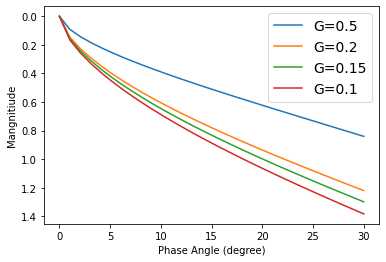

In [133]:
A1,A2 = 3.332,1.862
B1,B2 = 0.631,1.218
C1,C2 = 0.986,0.238
def calW(alpha):
    return np.exp(-90.56*np.tan(alpha/2)**2)
def calphiiS(i,alpha):
    Ci = C1
    if i == 2 :
        Ci = C2
    aa = 0.119+1.341*np.sin(alpha)-0.754*np.sin(alpha)**2
    return 1-Ci*np.sin(alpha)/aa
def calphiiL(i,alpha):
    Ai = A1
    Bi = B1
    if i == 2 :
        Ai = A2
        Bi = B2
    return np.exp(-Ai*np.tan(alpha/2)**Bi)
def calphii(i,alpha):
    W = calW(alpha)
    return W*calphiiS(i,alpha)+(1-W)*calphiiL(i,alpha)
def calHalpha(alpha,G,H):
    aa = (1-G)*calphii(1,alpha)+G*calphii(2,alpha)
    return H - 2.5*np.log10(aa)
def calpromixHalpha(alpha,G,H):
    aa = (1-G)*calphiiL(1,alpha)+G*calphiiL(2,alpha)
    return H - 2.5*np.log10(aa)
#plot 
alpha_degree = np.linspace(0,30,30)
alpha = alpha_degree/180*np.pi
ax = plt.gca()
ax.invert_yaxis()
plt.plot(alpha_degree,calpromixHalpha(alpha,0.5,0),label = 'G=0.5')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.2,0),label = 'G=0.2')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.15,0),label = 'G=0.15')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.1,0),label = 'G=0.1')
plt.legend(fontsize=14)
plt.xlabel("Phase Angle (degree)")
plt.ylabel("Mangnitiude");

##### cal  $F_v^{ref}(\lambda)$

$F_v^{ref}(\lambda) = (\frac{D}{2\Delta})^2 \frac{\Psi(\alpha,G)}{q(G)}[1-\epsilon(\lambda)]F_v^{\odot}$

$F_v^{\odot}=(\frac{R_{\odot}}{r})^2\pi B_v(T_{\odot},\lambda), T_{\odot} = 5,778K, R_{\odot} = 0.00465AU$

$B_v(T_{\odot},\lambda) = \frac{2hc^2}{\lambda ^5} \cdot \frac{1}{\exp(\frac{hc}{\lambda k_B T})-1}$

In [154]:
qG = 0.29+0.684*G
def calcPlanckLambda(lambd, T):
    return np.where(
        (lambd <= 0.0) | (T <= 0.0),
        0.0,
        (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)  )
def calFsun(lamda,d):
    return (Rsun/(d*au))**2*pi*calcPlanckLambda(lamda,Tsun)
def calFref(D,delta,d,alpha,lamda,epsiLamda):
    cons = (0.5*D/(delta*au))**2*(1-epsiLamda)/qG
    Fref = cons*calpromixHalpha(alpha,G,Hv)*calFsun(lamda,d)
    #print(f'hg={calpromixHalpha(alpha,G,Hv)}')
    return Fref*(lamda)**2/cl*1e29
print(f'G = {G}, Hv = {Hv}')

G = 0.15, Hv = 20


##### test plank

/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: invalid value encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)


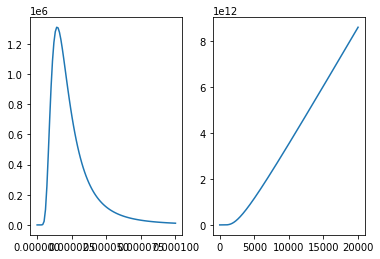

In [ ]:
lamdaa = np.linspace(0,100e-6,100)
pl1 = calcPlanckLambda(lamdaa,200)
plt.subplot(1,2,1)
plt.plot(lamdaa,pl1)
Ttt = np.linspace(0,20000,1000)
pl2 = calcPlanckLambda(2e-6,Ttt)
plt.subplot(1,2,2)
plt.plot(Ttt,pl2)

### NEATM Model with reflected

In [ ]:
def neatm_w34(Ndd,eta,D,eps,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*eps*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (eps*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def neatm_w12Flected(Ndd,eta,D,eps,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*eps*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (eps*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29 + calFref(D,delta,dd,alpha,lamda,eps)
    return F
def Model_neatm_rehhq(theta,x,lamda):
    eta,D,eps = theta
    delta,d,alpha = x
    lamda1,lamda2,lamda3,lamda4= lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    # calc w1 w2
    for i in range(0,int(nn/4)):
        flux[i] = neatm_w12Flected(Ndd,eta,D,eps,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/4),int(nn/2)):
        flux[i] = neatm_w12Flected(Ndd,eta,D,eps,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    # calc w3 w4
    for i in range(int(nn*3/4),nn):
        flux[i] = neatm_w34(Ndd,eta,D,eps,delta[i],d[i],alpha[i],lamda3*1e-6,A)
    for i in range(int(nn*3/4),nn):
        flux[i] = neatm_w34(Ndd,eta,D,eps,delta[i],d[i],alpha[i],lamda4*1e-6,A)
    return flux

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [ ]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']


#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [ ]:
y1,y2,y3,y4 = [],[],[],[]
raw = np.loadtxt('fobs.txt')
for i in range(len(raw)):
    if i %4==0:
        y1.append(raw[i][1])
    elif i %4==1:
        y2.append(raw[i][1])
    elif i %4==2:
        y3.append(raw[i][1])
    elif i %4==3:
        y4.append(raw[i][1])
w1 = np.array(y1)
w2 = np.array(y2)
w3 = np.array(y3)
w4 = np.array(y4)
print(w1)

[0.04176 0.06747 0.03763 0.05754 0.03654 0.03773 0.03988 0.03801 0.04226
 0.04929 0.04681 0.04333 0.0534  0.03407 0.0413  0.04852 0.04942 0.06326
 0.07508 0.04906 0.04028 0.05296 0.0483  0.04309 0.0359  0.03973 0.0686
 0.04454 0.03715 0.0483  0.03808 0.04389 0.06898 0.0483  0.07797 0.05882
 0.04608 0.08105 0.03812 0.04207 0.0389  0.05576 0.04184 0.03948 0.05016
 0.05587 0.04122 0.04733 0.03933 0.03933 0.04516]


In [183]:
name = '2ev5'
obsdat12 = np.append(w1,w2)
obsdat34 = np.append(w3,w4)
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N*2,d_N*2,alpha_N*2)
half = int(len(delta_N)/2)

array([10,  9,  8,  7])

##### plot $F_v^{ref}-\lambda$

/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: invalid value encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)


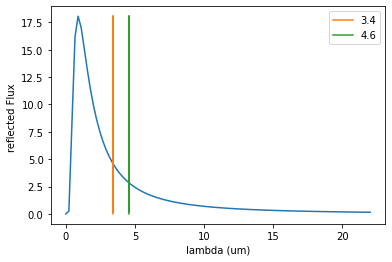

In [ ]:
delta0,d0,alpha0 = x[0][10],x[1][10],x[2][10]
arraylam = np.linspace(0,22,100)
refledF = calFref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
plt.plot(arraylam,refledF)
plt.plot([3.4]*100,refledF,label = '3.4')
plt.plot([4.6]*100,refledF,label = '4.6')
plt.legend() 
plt.xlabel("lambda (um)")
plt.ylabel("reflected Flux ");


#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal   $F_v^{ref}$ in W1/W2


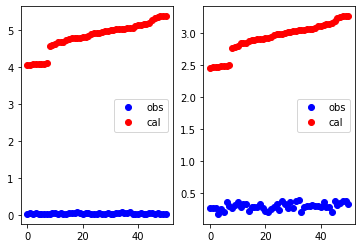

In [186]:
fluxRef1 = calFref(346,delta_N[0:half],d_N[0:half],alpha_N[0:half],3.4e-6,epsi)
fluxRef2 = calFref(346,delta_N[0:half],d_N[0:half],alpha_N[0:half],4.6e-6,epsi)
plt.subplot(1,2,1)
plt.plot(w1,'bo',label = 'obs')
plt.plot(fluxRef1,'ro',label = 'cal')
plt.legend()
plt.subplot(1,2,2)
plt.plot(w2,'bo',label = 'obs')
plt.plot(fluxRef2,'ro',label = 'cal')
plt.legend()

No handles with labels found to put in legend.
/tmp/ipykernel_366405/114148979.py:10: RuntimeWarning: divide by zero encountered in true_divide
  cons = (0.5*D/(delta*au))**2*(1-epsiLamda)/qG
/tmp/ipykernel_366405/4284620675.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(xdelta),yflux1)
No handles with labels found to put in legend.
/tmp/ipykernel_366405/114148979.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return (Rsun/(d*au))**2*pi*calcPlanckLambda(lamda,Tsun)
No handles with labels found to put in legend.


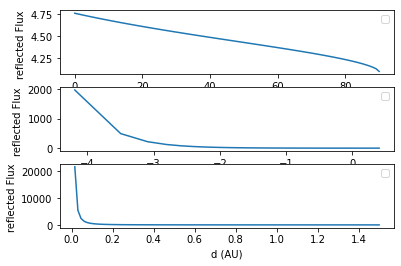

In [198]:
xalpha = np.linspace(0,pi/2,100)
yflux = calFref(346,delta_N[10],d_N[10],pi/2-xalpha,3.4e-6,0.9)
plt.subplot(3,1,1)
plt.plot(xalpha/pi*180,yflux)
plt.xlabel("alpha (degree)")
plt.ylabel("reflected Flux ");
plt.legend()
xdelta = np.linspace(0,1.5,100)
yflux1 = calFref(346,xdelta,d_N[10],alpha_N[10],3.4e-6,0.9)
plt.subplot(3,1,2)
plt.plot(np.log(xdelta),yflux1)
plt.xlabel("delta (AU)")
plt.ylabel("reflected Flux ");
plt.legend()
xd = np.linspace(0,1.5,100)
yflux2 = calFref(346,delta_N[10],xd,alpha_N[10],3.4e-6,0.9)
plt.subplot(3,1,3)
plt.plot(xd,yflux2)
plt.xlabel("d (AU)")
plt.ylabel("reflected Flux ");
plt.legend()

#### cal $F^{ref} integral$

sum=1.972949499865067
sum=1.97292609903764
sum=1.9729429655846236
sum=1.972916329727615
sum=1.9729041191455925
sum=1.9728716979167695
sum=1.972921603826483
sum=1.9727524719778986
sum=1.96442972944532
sum=1.9634342373794376
sum=1.9628208857421738
sum=1.9606397195697567
sum=1.9604012176037557
sum=1.9601580198742552
sum=1.958465195921501
sum=1.9575890954298025
sum=1.9569321403285789
sum=1.956525200487689
sum=1.9562627225792584
sum=1.956130331800773
sum=1.9557741844387477
sum=1.95544989417491
sum=1.954178509182849
sum=1.9516682937709156
sum=1.9513703992956197
sum=1.9512111176747025
sum=1.9505910037914724
sum=1.950010169376722
sum=1.9486765168447364
sum=1.948077236101216
sum=1.9472293712600925
sum=1.9470048250291994
sum=1.9464905981051197
sum=1.9459728769588784
sum=1.9458143791555988
sum=1.945278367770776
sum=1.9449347376039157
sum=1.9446018571998571
sum=1.9440413698399928
sum=1.9418502378774207
sum=1.9411562956003912
sum=1.9399458681756672
sum=1.93921318204182
sum=1.9388597544564494
sum=1.

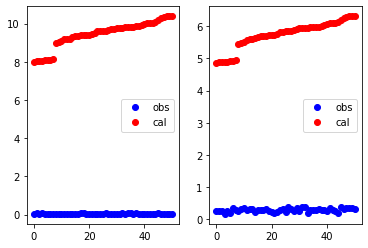

In [168]:
def ref(Ndd,D,eps,delta,dd,alpha,lamda):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            integral = np.cos(phii)**2*np.cos(alpha-thei)
            summ = summ + dxdy*integral
    print(f'sum={summ}')
    F = summ*calFref(D,delta,dd,alpha,lamda,eps)
    return F
def Model_ref(D,x,lamda,eps):
    delta,d,alpha = x
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,nn):
        flux[i] = ref(Ndd,D,eps,delta[i],d[i],alpha[i],lamda)
    return flux
x_N = (delta_N[0:half],d_N[0:half],alpha_N[0:half])
fluxRef1 = Model_ref(346,x_N,3.4e-6,epsi)
fluxRef2 = Model_ref(346,x_N,4.6e-6,epsi)
plt.subplot(1,2,1)
plt.plot(w1,'bo',label = 'obs')
plt.plot(fluxRef1,'ro',label = 'cal')
plt.legend()
plt.subplot(1,2,2)
plt.plot(w2,'bo',label = 'obs')
plt.plot(fluxRef2,'ro',label = 'cal')
plt.legend()

##### cal $F_v^{th}$ in W1/W2 

/tmp/ipykernel_366405/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


Text(0.5, 0, 'n')

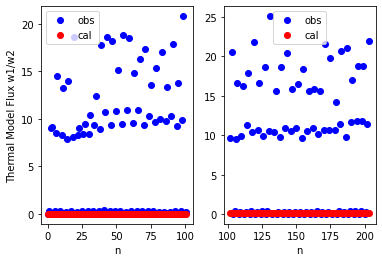

In [101]:
y = obsdat12
nt = np.arange(len(d_N))
theta = [3.4,346]
flux12 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=[3.4,4.6])
plt.subplot(1,2,1)
plt.plot(nt[0:half],obsdat12[0:half],'bo',label = 'obs')
plt.plot(nt[0:half],flux12[0:half],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(nt[half:nn],obsdat12[half:nn],'bo',label = 'obs')
plt.plot(nt[half:nn],flux12[half:nn],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

Text(0.5, 0, 'n')

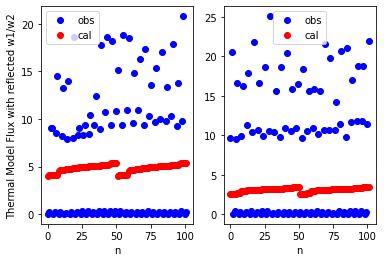

In [102]:
flux01 = flux12[0:half]+fluxRef1
flux02 = flux12[half:nn]+fluxRef2
plt.subplot(1,2,1)
plt.plot(y0[0:half],'bo',label = 'obs')
plt.plot(flux01,'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux with reflected w1/w2");
plt.subplot(1,2,2)
plt.plot(y0[half:nn],'bo',label = 'obs')
plt.plot(flux02,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}$ in W3\W4

In [103]:
y = obsdat34
nt = np.arange(len(d_N))
theta = [3.0,300]
flux34 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
plt.subplot(1,2,1)
plt.plot(y[0:half],'bo',label = 'obs')
plt.plot(flux34[0:half],'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w3/w4");
plt.subplot(1,2,2)
plt.plot(y[half:nn],'bo',label = 'obs')
plt.plot(flux34[half:nn],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")


ValueError: too many values to unpack (expected 2)

##### cal $F_v^{ref}$ in W3/W4

[0.22724259 0.66398851 0.66399328 0.66895229 0.67396159 0.6790218
 0.68930211 0.69190615 0.69451846 0.69714911 0.69978804 0.69979313
 0.70244556 0.70511665 0.70779617 0.70780133 0.71049459 0.7132068
 0.7159276  0.71593288 0.71866761 0.72142165 0.72418443 0.72418979
 0.72696674 0.73256881 0.73539414 0.74683582 0.75264251 0.75850906
 0.76444191 0.91164269]


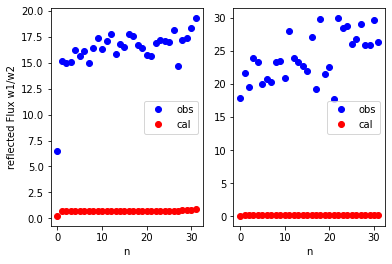

In [ ]:
fluxRef341 = calFref(346,delta_N[0:32],d_N[0:32],alpha_N[0:32],12e-6,epsi)
fluxRef342 = calFref(346,delta_N[32:64],d_N[32:64],alpha_N[32:64],22e-6,epsi)
plt.subplot(1,2,1)
plt.plot(y[0:32],'bo',label = 'obs')
plt.plot(fluxRef341,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("reflected Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(y[32:64],'bo',label = 'obs')
plt.plot(fluxRef342,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
print(fluxRef341)

### MCMC

/tmp/ipykernel_366405/939776259.py:34: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_366405/939776259.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


[ 2.12255072  2.13395265  2.13816744  2.13827456  2.14072175  2.1475004
  2.14858376  2.15905052  2.39053284  2.40749345  2.41830751  2.45180677
  2.45551576  2.45902696  2.48288014  2.49475332  2.50379579  2.5096697
  2.51286301  2.51495121  2.51864852  2.52379219  2.54014489  2.5711814
  2.5745159   2.57663203  2.58392932  2.59005759  2.60618328  2.61230587
  2.62200712  2.62534397  2.63108748  2.63639418  2.63840843  2.64452126
  2.64814778  2.65142381  2.65789258  2.6810891   2.68757374  2.70089931
  2.70781124  2.71097834  2.72464396  2.76050908  2.78949303  2.80394129
  2.8183198   2.8183198   2.8183198   1.39225666  1.39971187  1.40247108
  1.40253668  1.40413752  1.40856898  1.40928306  1.41611341  1.5669952
  1.57802238  1.58505704  1.60682056  1.60922927  1.6115078   1.62698992
  1.63469366  1.6405613   1.64437511  1.64644403  1.64780273  1.65019343
  1.65353644  1.66413759  1.68425112  1.68640895  1.68778323  1.69250723
  1.69647153  1.7069162   1.71087511  1.71715413  1.719

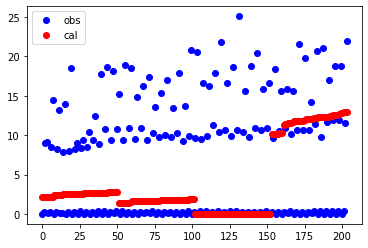

In [106]:
y = np.append(obsdat12,obsdat34)
nt = np.arange(len(d_N))
plt.plot(y,'bo',label = 'obs')
theta = [2.8,250,0.9]
flux = Model_neatm_rehhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
plt.plot(flux,'ro',label = 'cal')
plt.legend()
print(flux)
print(y)